In [2]:
# #### Install packages ####
# if (!requireNamespace("BiocManager", quietly = TRUE))
#   install.packages("BiocManager")

# BiocManager::install(c("Seurat", "Matrix"))

# install.packages("remotes")
# remotes::install_github("cole-trapnell-lab/monocle3")

In [ ]:
#### Load packages ####
library(monocle3)  # pseudotime analysis
library(dplyr)

In [ ]:
#### Load data ####
source(file.path(
  "..",
  "preprocessing",
  "load_and_prepare_seurat.R"
))

expression_matrix <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_umi_matrix.csv.gz"
)
metadata_path <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_cell_cluster_info.txt"
)

seu_obj <- adult_human_heart(
  expression_matrix = expression_matrix,
  metadata_path = metadata_path
)

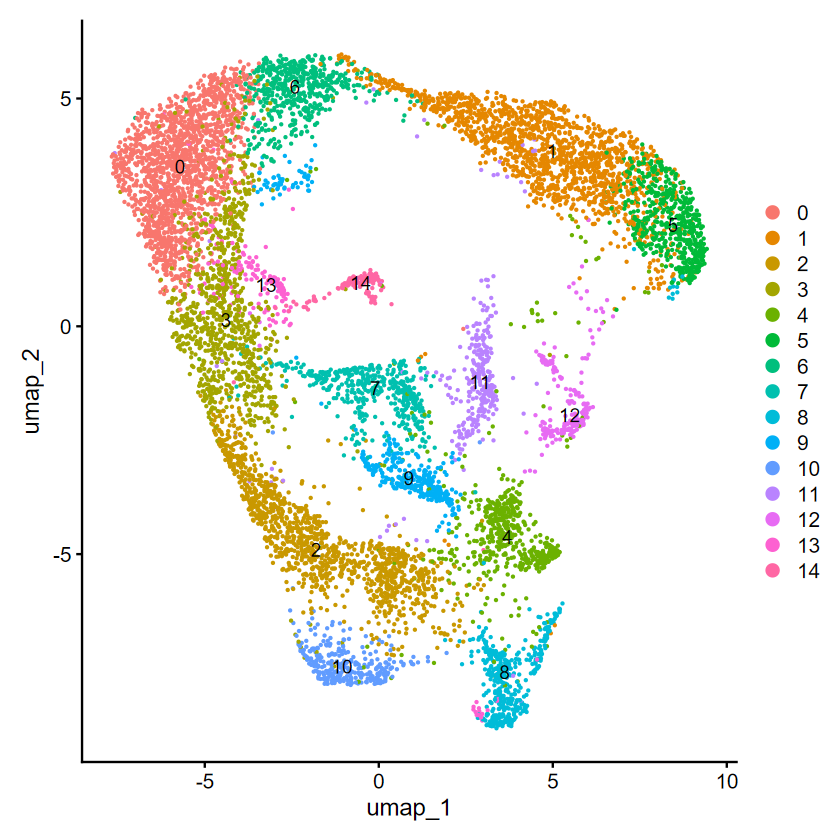

In [5]:
DimPlot(seu_obj, reduction = "umap", label = TRUE)

In [6]:
#### Convert Seurat object to Monocle3 Cell Data Set ####
# Extract the count matrix, cell metadata, and feature metadata
expression_matrix <- GetAssayData(seu_obj, assay = "RNA", layer = "counts")
cell_metadata <- seu_obj@meta.data
gene_annotation <- data.frame(
  gene_short_name = rownames(expression_matrix),
  row.names = rownames(expression_matrix)
)

# Create the Monocle3 Cell Data Set
cds <- new_cell_data_set(expression_matrix,
  cell_metadata = cell_metadata,
  gene_metadata = gene_annotation
)

No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


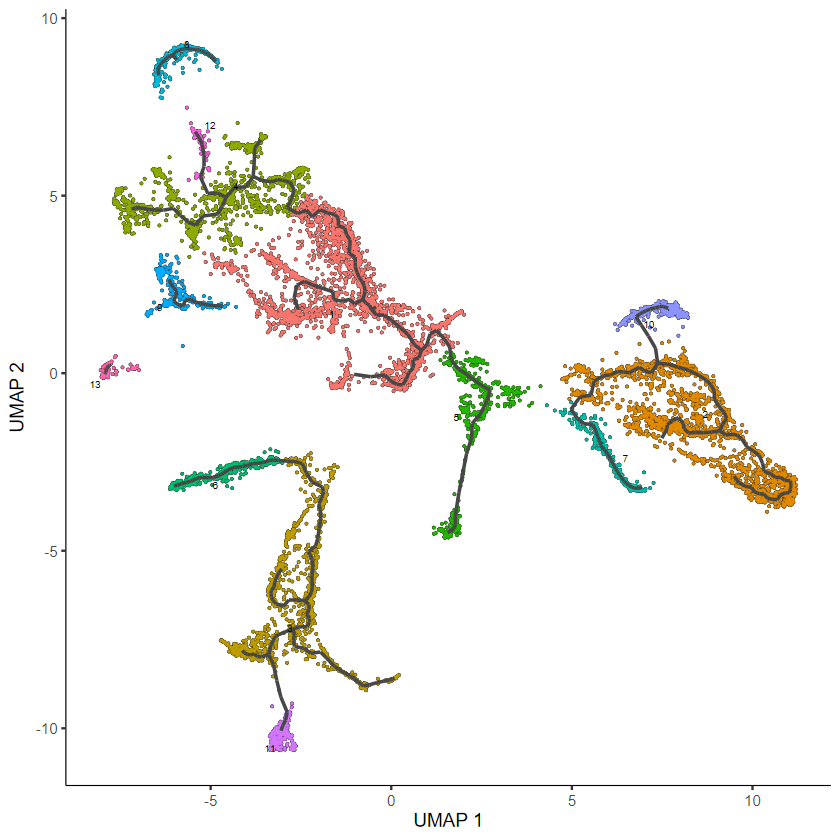

In [7]:
#### Working with a Monocle3 Cell Data Set ####
# Preprocess and perform PCA reduction
cds <- preprocess_cds(cds, num_dim = 100)
# Reduce dimensions using UMAP
cds <- reduce_dimension(cds, reduction_method = "UMAP")
# Cluster cells
cds <- cluster_cells(cds, reduction_method = "UMAP")
# Learn the trajectory graph
cds <- learn_graph(cds)

# Plot the learned trajectory graph
plot_cells(cds,
  color_cells_by = "cluster",
  label_groups_by_cluster = FALSE,
  label_leaves = FALSE,
  label_branch_points = FALSE
)

In [12]:
#### Choose the root cells of the trajectories ####
# 1: identify cells with expression of a gene of interest
# marker_expression <- as.matrix(cds@assays@data$counts["GeneA", ])
# root_cells <- names(
#   marker_expression[marker_expression > quantile(marker_expression, 0.9)]
# )
# cds <- order_cells(cds, root_cells = root_cells)

# 2: Start from a certain cluster
# Get cell names from a cluster identified in the Seurat object
root_cells <- colnames(seu_obj)[seu_obj$seurat_clusters == 1]
cds <- order_cells(cds, root_cells = root_cells)

Cells aren't colored in a way that allows them to be grouped.



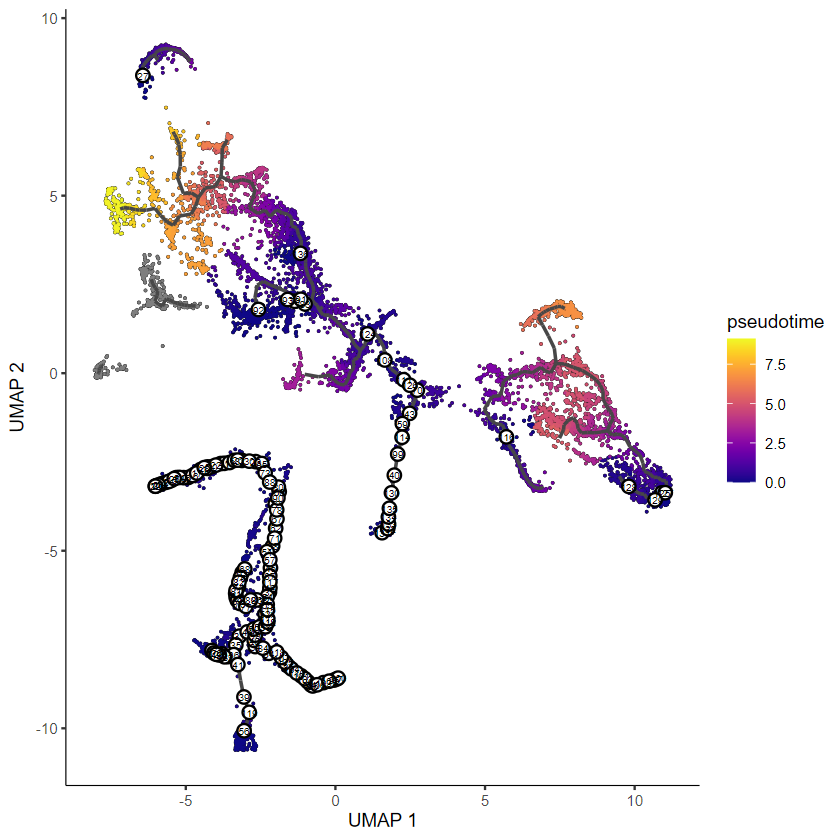

In [13]:
## Now you have a trajectory graph to visualize
# Plot cells colored by pseudotime
plot_cells(cds,
  color_cells_by = "pseudotime",
  label_groups_by_cluster = FALSE,
  label_leaves = FALSE,
  label_branch_points = FALSE
)

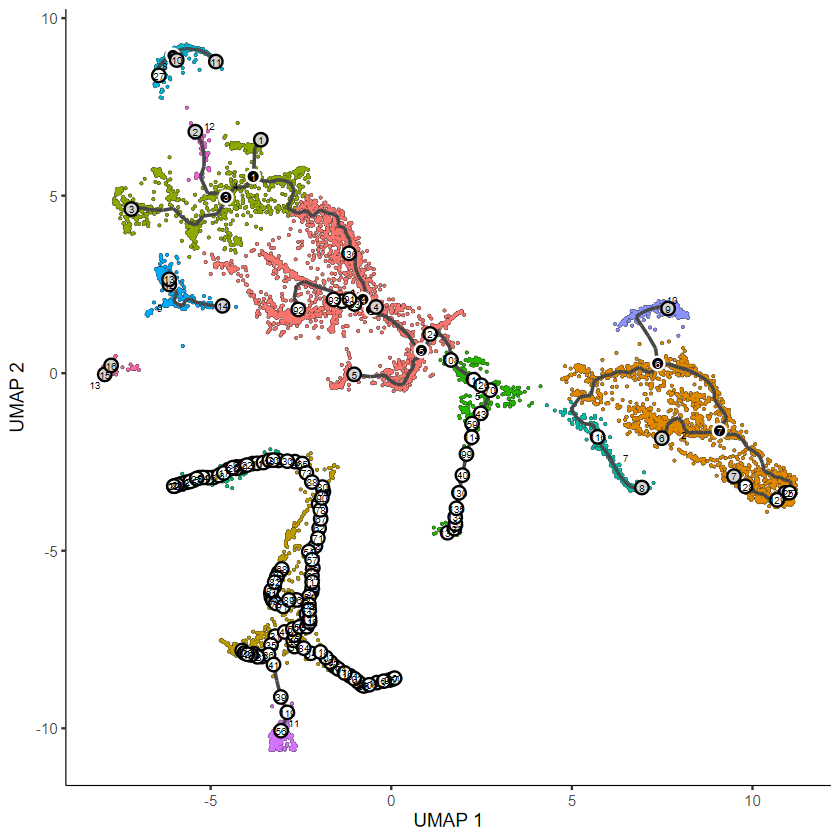

In [14]:
plot_cells(cds,
  color_cells_by = "cluster",
  show_trajectory_graph = TRUE,
  label_leaves = TRUE,
  label_branch_points = TRUE
)

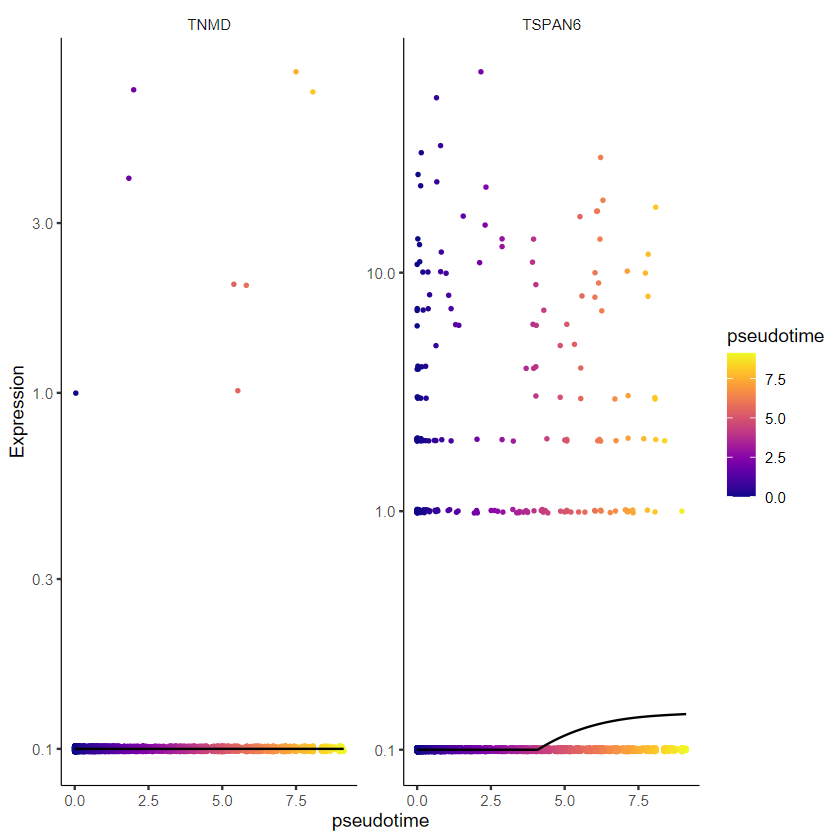

In [15]:
# Plot the expression of specific genes over pseudotime
plot_genes_in_pseudotime(
  cds_subset = cds[1:2, ],
  min_expr = 0.1,
  cell_size = 0.5,
  nrow = 2,
  ncol = 5
)

  |=======================================================| 100%, Elapsed 30:22

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


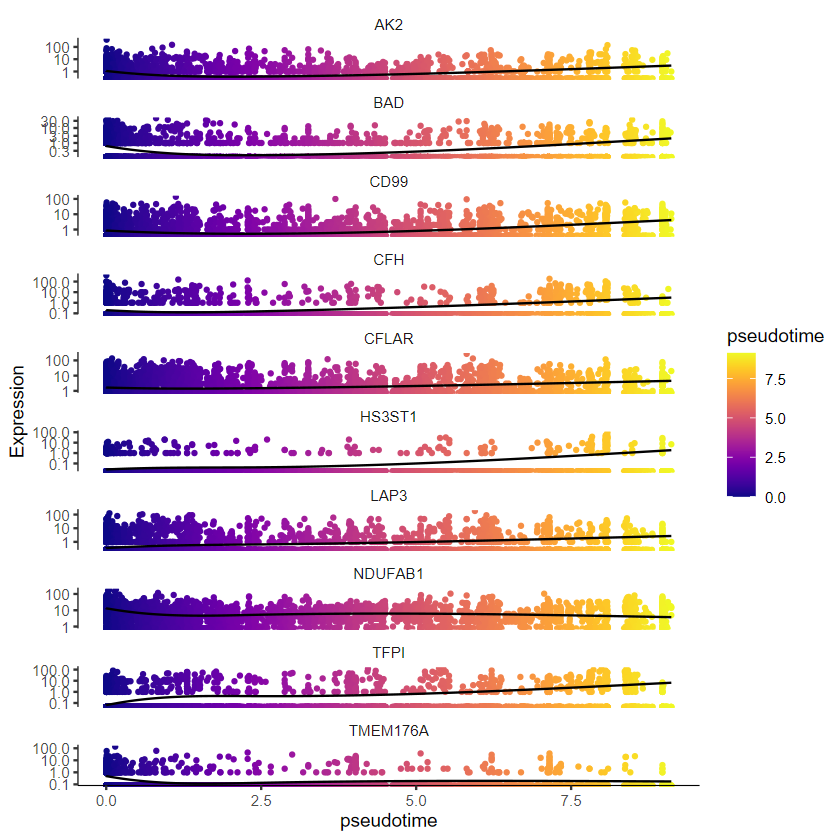

In [16]:
#### Find genes differentially expressed over pseudotime ####
# good for identifying genes that change expression over the trajectory
# and may be involved in the process
# NOTE: This step may take a while to run
deg_pseudotime <- graph_test(
  cds,
  neighbor_graph = "principal_graph"
)

# Filter significant genes
deg_sig <- deg_pseudotime %>%
  filter(q_value < 0.05) %>%
  arrange(q_value)

# Subset the CDS object to include only the genes of interest
genes_of_interest <- deg_sig$gene_short_name[1:10]

# Ensure the gene names are in the rowData of the CDS object
cds_subset <- cds[rowData(cds)$gene_short_name %in% genes_of_interest, ]

# Plot the expression of these genes in pseudotime
plot_genes_in_pseudotime(cds_subset)